# Sparse Group Lasso (SGL)

Run Sparse Group Lasso (SGL) on the Human Connectome Project Young Adult (HCP-YA) 1200 Subject Release bundle profiles processed with pyAFQ probalistic Constrained Spherical Deconvolution (CSD) tractometry with Diffusion Kurtosis Imaging model (DKI) scalars:
- Fractional Anisotropy (FA)
- Mean Diffusivity (MD)
- Mean Kurtosis (MK)
- Axonal Water Fraction (AWF)

**Goal** Identify variance explained in Reading Scores attributed to white matter

##### Runtime Environment Dependency Checks

Ensure AFQ Insight version

Ensure correct version of sklearn:
https://github.com/scikit-optimize/scikit-optimize/issues/978

In [23]:
def sklearn_version():
    import pkg_resources
    pkg_resources.require("scikit-learn==0.23.2")
    import sklearn
    print(sklearn.__version__)
    
sklearn_version()

0.23.2


Ensure correct version of scipy: https://github.com/scikit-optimize/scikit-optimize/issues/981

In [24]:
def scipy_version():
    import pkg_resources
    pkg_resources.require("scipy==1.5.3")
    import scipy
    print(scipy.__version__)
    
scipy_version()

1.5.3


## Dataset

##### Dataset Information

Human Connectome Project Young Adult (HCP-YA)
- https://www.humanconnectome.org/study/hcp-young-adult

Using Human Connectome Project Young Adult (HCP-YA) 1200 Subject Release:
- https://www.humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release

    Release Reference Manual:
    - https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf

In [158]:
def _get_subjects():
    """
    Helper function to identify HCP-YA subjects that have been processed by pyAFQ
    """
    import s3fs
    
    fs = s3fs.S3FileSystem()
    
    return [f.split('sub-')[1] for f in fs.glob('hcp.afq/derivatives/afq/sub-*')]

#### `nodes.csv`

Download and combine all HCP-YA 1200 Subject pyAFQ bundle profiles from `hcp.afq` S3 repository

In [159]:
def _generate_nodes_csv(callsum_only=False):
    """
    genearate `nodes.csv` from HCP-YA pyAFQ bundle profiles.
    """
    import s3fs
    import os
    from os.path import exists
    import pandas as pd
    
    if exists('nodes.csv'):
        print('nodes.csv already exists! to regenerate delete file and rerun.')
        return

    fs = s3fs.S3FileSystem()

    dfs = []
    
    subjects = _get_subjects()
        
    os.makedirs('hcp.afq/test', exist_ok=True)
    
    for subject in subjects:
        # NOTE assuming one session
        fname = f'sub-{subject}_dwi_space-RASMM_model-CSD_desc-prob-afq_profiles.csv'
        local_fname = f'hcp.afq/test/{fname}'
        
        if not exists(local_fname):
            if fs.ls(f'hcp.afq/derivatives/afq/sub-{subject}/ses-01/{fname}'):
                fs.get(
                    f'hcp.afq/derivatives/afq/sub-{subject}/ses-01/{fname}',
                    local_fname
                )
        
        if exists(local_fname):
            profiles = pd.read_csv(local_fname, index_col=[0])
            profiles.insert(0, 'subjectID', subject)
        
            dfs.append(profiles)
        
    combined_df = pd.concat(dfs)
    
    # filter the available tracts to only those in callosum
    if callsum_only:
        combined_df = combined_df[combined_df.tractID.isin(['AntFrontal', 'Motor', 'Occipital', 'Orbital',
           'PostParietal', 'SupFrontal', 'SupParietal', 'Temporal'])]

    combined_df.reset_index(inplace=True, drop=True)
    combined_df.to_csv('nodes.csv', index=False)

In [161]:
_generate_nodes_csv()

#### `subjects.csv`

##### HCP-YA 1200 Subject Behavioral Data

**NOTE you must have access to HCP dataset**

To get access "Create an Account":
- https://db.humanconnectome.org/

**NOTE you must manually download the behavoiral data locally**

Data Dictonary:
- https://wiki.humanconnectome.org/display/PublicData/HCP-YA+Data+Dictionary-+Updated+for+the+1200+Subject+Release

**WARNING: Potential file name collision.** 
  
  - This `subjects.csv` is different from the `HCP-YA-XGBoost.ipynb` `subjects.csv` as it contains only the reading behavioral trait.

In [167]:
def _generate_subjects_csv():
    """
    generate `subjects.csv` from entire HCP-YA behavioral data
    """
    import os
    from os.path import exists
    import errno
    import pandas as pd
    
    if exists('subjects.csv'):
        print('subjects.csv already exists! to regenerate delete file and rerun.')
        return
        
    if not exists('unrestricted_1200_behavioral.csv'):
        raise FileNotFoundError(
            errno.ENOENT, os.strerror(errno.ENOENT),
            'unrestricted_1200_behavioral.csv'
        )
        
    subjects = _get_subjects()
    
    df = pd.read_csv('unrestricted_1200_behavioral.csv', usecols=['Subject', 'ReadEng_Unadj'])
    # ensure subjects match with HCP-YA pyAFQ processing
    df = df[df['Subject'].isin(list(map(int, subjects)))]
    df = df.rename(columns={'Subject': 'subjectID'})
    df.to_csv("subjects.csv", index=False)

In [168]:
_generate_subjects_csv()

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Scheduler for 3.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. Th

### Baseline

Following SGL examples:
- https://github.com/richford/afq-insight-paper/tree/main/notebooks
- https://richiehalford.org/AFQ-Insight/auto_examples/plot_age_regression.html#sphx-glr-auto-examples-plot-age-regression-py

### Model

Taken from:

- https://github.com/nrdg/dhcp_afq/blob/master/sgl_age_regression.ipynb

In [4]:
from dask.distributed import Client, LocalCluster
import logging

cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=4,
    silence_logs=logging.DEBUG
)

client = Client(cluster, heartbeat_interval=10000)
print(client.dashboard_link)

distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:62820
distributed.scheduler - INFO -   dashboard at:            127.0.0.1:8787
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:62822'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:62823'
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:62825', name: 0, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:62825
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://127.0.0.1:62824', name: 1, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:62824
distributed.core - INFO - Startin

http://127.0.0.1:8787/status


In [7]:
def get_cv_results(n_repeats=5, n_splits=10,
                   power_transformer=False, 
                   shuffle=False,
                   ensembler=None,
                   target_transform_func=None,
                   target_transform_inverse_func=None,
                   n_estimators=10,
                   trim_nodes=0,
                   square_features=False):
    import afqinsight as afqi
    import numpy as np
    from sklearn.model_selection import RepeatedKFold
    from sklearn.metrics import median_absolute_error, r2_score
    from datetime import datetime
    import joblib
    
    X, y, groups, feature_names, group_names, subjects, *_ = afqi.load_afq_data(
        '.',
        target_cols=['ReadEng_Unadj'],
        dwi_metrics=['dki_fa', 'dki_md', 'dki_mk', 'dki_awf']
    )
    
    if shuffle:
        rng = np.random.default_rng()
        y_fit = rng.permutation(y)
    else:
        y_fit = np.copy(y)
        
    if trim_nodes > 0:
        grp_mask = np.zeros_like(groups[0], dtype=bool)
        grp_mask[trim_nodes:-trim_nodes] = True
        X_mask = np.concatenate([grp_mask] * len(groups))

        groups_trim = []
        start_idx = 0
        
        for grp in groups:
            stop_idx = start_idx + len(grp) - 2 * trim_nodes
            groups_trim.append(np.arange(start_idx, stop_idx))
            start_idx += len(grp) - 2 * trim_nodes
            
        X_trim = X[:, X_mask]
    elif trim_nodes == 0:
        groups_trim = [grp for grp in groups]
        X_trim = np.copy(X)
    else:
        raise ValueError("trim_nodes must be non-negative.")
        
    if square_features:
        _n_samples, _n_features = X_trim.shape
        X_trim = np.hstack([X_trim, np.square(X_trim)])
        groups_trim = [np.concatenate([g, g + _n_features]) for g in groups_trim]
    
    cv = RepeatedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=1729
    )

    cv_results = {}
    pipe_skopt = afqi.make_afq_regressor_pipeline(
        imputer_kwargs={"strategy": "median"},
        use_cv_estimator=True,
        feature_transformer=power_transformer,
        scaler="standard",
        groups=groups_trim,
        verbose=0,
        pipeline_verbosity=False,
        tuning_strategy="bayes",
        cv=3,
        n_bayes_points=9,
        n_jobs=28,
        l1_ratio=[0.0, 1.0],
        eps=5e-2,
        n_alphas=100,
        ensemble_meta_estimator=ensembler,
        ensemble_meta_estimator_kwargs={
            "n_estimators": n_estimators,
            "n_jobs": 1,
            "oob_score": True,
            "random_state": 1729,
        },
        target_transform_func=target_transform_func,
        target_transform_inverse_func=target_transform_inverse_func,
    )

    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X_trim, y_fit)):
        start = datetime.now()

        X_train, X_test = X_trim[train_idx], X_trim[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]

        with joblib.parallel_backend("dask"):
            pipe_skopt.fit(X_train, y_train)

        cv_results[cv_idx] = {
            "pipeline": pipe_skopt,
            "train_idx": train_idx,
            "test_idx": test_idx,
            "y_pred": pipe_skopt.predict(X_test),
            "y_true": y_test,
            "test_mae": median_absolute_error(y_test, pipe_skopt.predict(X_test)),
            "train_mae": median_absolute_error(y_train, pipe_skopt.predict(X_train)),
            "test_r2": r2_score(y_test, pipe_skopt.predict(X_test)),
            "train_r2": r2_score(y_train, pipe_skopt.predict(X_train)),
        }
        
        if ((target_transform_func is not None)
            or (target_transform_inverse_func is not None)):
            cv_results[cv_idx]["coefs"] = [
                est.coef_ for est
                in pipe_skopt.named_steps["estimate"].regressor_.estimators_
            ]
            cv_results[cv_idx]["alpha"] = [
                est.alpha_ for est
                in pipe_skopt.named_steps["estimate"].regressor_.estimators_
            ]
            cv_results[cv_idx]["l1_ratio"] = [
                est.l1_ratio_ for est
                in pipe_skopt.named_steps["estimate"].regressor_.estimators_
            ]
        else:
            cv_results[cv_idx]["coefs"] = [
                est.coef_ for est
                in pipe_skopt.named_steps["estimate"].estimators_
            ]
            cv_results[cv_idx]["alpha"] = [
                est.alpha_ for est
                in pipe_skopt.named_steps["estimate"].estimators_
            ]
            cv_results[cv_idx]["l1_ratio"] = [
                est.l1_ratio_ for est
                in pipe_skopt.named_steps["estimate"].estimators_
            ]
        
        if ensembler is None:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["optimizer"] = pipe_skopt.named_steps["estimate"].regressor_.bayes_optimizer_                
            else:
                cv_results[cv_idx]["optimizer"] = pipe_skopt.named_steps["estimate"].bayes_optimizer_

        print(f"CV index [{cv_idx:3d}], Elapsed time: ", datetime.now() - start)
        
    return cv_results, y_fit

In [8]:
results = get_cv_results(
        n_splits=5, n_repeats=1, power_transformer=False,
        ensembler="serial-bagging", shuffle=False, n_estimators=20,
        trim_nodes=0, square_features=False)

CV index [  0], Elapsed time:  5:20:23.853987
CV index [  1], Elapsed time:  5:30:01.494123
CV index [  2], Elapsed time:  6:14:51.342470
CV index [  3], Elapsed time:  9:24:21.754107
CV index [  4], Elapsed time:  10:36:27.976288


In [9]:
def save_cv_results(results, fname):
    import pickle
    
    with open(fname, "wb") as fp:
        pickle.dump(results, fp)
        
save_cv_results(results, 'sgl_hcp_1200_dki_reading_regression_all_bundles.pkl')

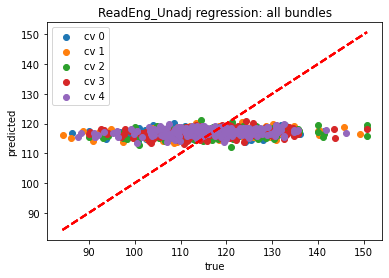

In [147]:
def plot_results(results):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots()
    for cv in results[0].keys():
        ax.scatter(results[0][cv]['y_true'], results[0][cv]['y_pred'], label=f'cv {cv}')
        ax.plot([y.min(), y.max()],
            [y.min(), y.max()],
            '--r', linewidth=2)
        ax.set_xlabel('true')
        ax.set_ylabel('predicted')
        ax.set_title('ReadEng_Unadj regression: all bundles')
        ax.legend()
    plt.show()
    
plot_results(results)

- Smaller predicted variance is indication of over regularization

**NOTE** could scale model predictions so more accurate (but ideally model should learn variance)

In [151]:
def score_results(results):
    import numpy as np
    print("train", np.mean([results[0][cv]['train_r2'] for cv in results[0].keys()]))
    print("test", np.mean([results[0][cv]['test_r2'] for cv in results[0].keys()]))
    
score_results(results)

train 0.09852847962954728
test 0.03629903755470283


**NOTE** ~3.5% variance explained is reasonable for HCP dataset 

- Rasero et al 2021. _Integrating across neuroimaging modalities boosts prediction accuracy of cognitive ability_
  https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008347

#### Model Coefficients

In [104]:
import afqinsight as afqi

X, y, groups, feature_names, group_names, subjects, *_ = afqi.load_afq_data(
    '.',
    target_cols=['ReadEng_Unadj'],
    dwi_metrics=['dki_fa', 'dki_md', 'dki_mk', 'dki_awf']
)

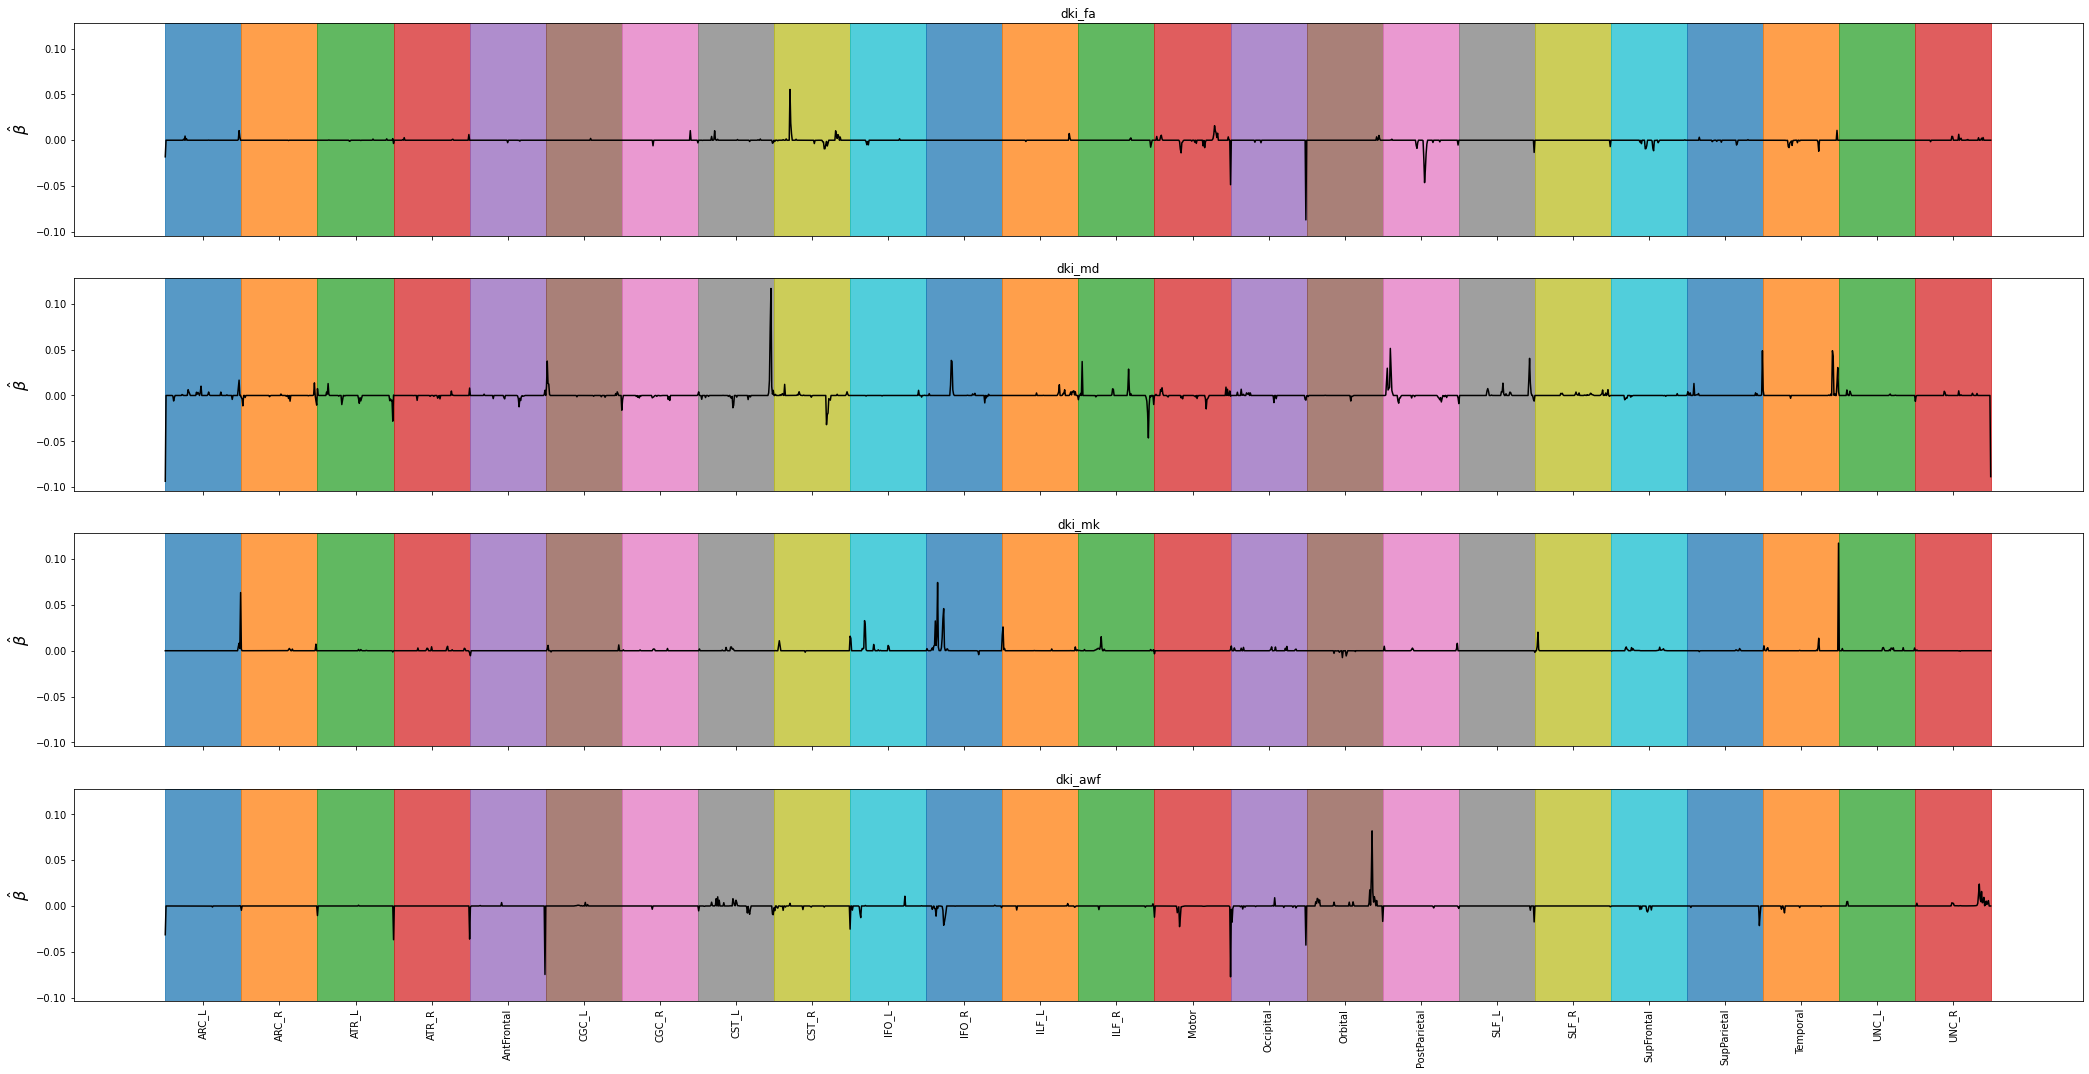

In [141]:
def model_coeffcients(results, groups, group_names):
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
  
    # 5 cvs
    # 20 estimators
    # 24 bundles x 4 metrics = 96 x 100 nodes = 9600 coefficients

    # average coeficents across cvs and estimators, 24 bundles x 4 scalars x 100 nodes
    coef_avg = np.mean(
        [
            np.mean(
                np.array(results[0][cv]['coefs']),
                axis=0
            )
            for cv in results[0].keys()
        ],
        axis=0
    )
    
    scalars = ['dki_fa', 'dki_md', 'dki_mk', 'dki_awf']
    bundle_names = [grp_name[1] for grp_name in group_names[:24]]
    bundle_colors = sns.color_palette(n_colors=24)
    
    fig, axs = plt.subplots(nrows=len(scalars), sharex=True, sharey=True, figsize=(36,18))
    
    axs = axs.ravel()
    
    for i in range(len(scalars)):
        axs[i].set_title(scalars[i])
        sns.lineplot(
            ax=axs[i],
            data=coef_avg[2400*i:2400*(i+1)],
            color='k'
        )
        axs[i].set_xticks((np.array(range(len(bundle_names)))*100)+50)
        axs[i].set_xticklabels(bundle_names, rotation = 90, ha='center')
        axs[i].set_ylabel(r"$\hat{\beta}$", fontsize=16)
        for grp, grp_name, grp_color in zip(groups[:24], group_names[:24], bundle_colors):
            axs[i].axvspan(grp.min(), grp.max() + 1, color=grp_color, alpha=0.75, label=grp_name[1])

    plt.show()
    
model_coeffcients(results, groups, group_names)

**TODO**

- [ ] Use only callosal data (to compare with `callosum.ipynb`)

_SGL_

- [x] Get model coeffiecients -- https://richiehalford.org/AFQ-Insight/auto_examples/plot_age_regression.html#sphx-glr-auto-examples-plot-age-regression-py

- [ ] Use PCR and SGL? (**Follow up** this performed worse on HCP data in AFQ Insight paper)

- [ ] (Jason) Concerns over standardization -- if normalizing to mean zero then loosing some informatiion - ensure add mean (**Reconfirm representation**)
    
  - [ ] (Jason) Add column mean transformer DKI in AFQ insight for each bundle (**Clarification**)
  
- [ ] Run SGL on every behavioral predictor in HCP-YA?

_XGBoost_

- [x] XGBoost with behavioral predictors (see `HCP-YA-XGBoost.ipynb`)

_LASSO_

- [ ] Use straight scikit learns LASSO CV (see adams' afq-insight-paper notebooks)

_other_

- (Ariel) encoding/decoding behavior and dki profiles

**Validation:**

- [x] Compare model coefficients to XGBoost feature importance

    - Identifying some of same bundle and scalars, but not same nodes nor same importance to model...  

- [ ] Shuffle data see if predict same variance

- [ ] Remove certian bundles (e.g. PostParietal) data see effects